In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

pd.set_option("display.max_columns", 5400)
pd.set_option("display.max_colwidth", 500)

In [2]:
df = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")

### Data exploration

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


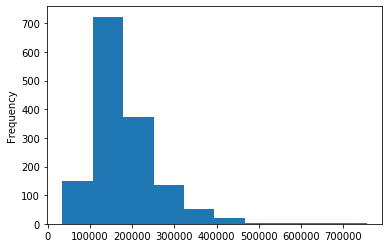

In [4]:
df["SalePrice"].plot(kind="hist");

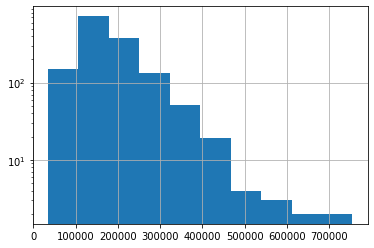

In [5]:
df["SalePrice"].hist(log=True);

In [6]:
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [7]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [8]:
df["HouseStyle"].value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

### Hypothesis:
* H<sub>0</sub>: None of the features in the dataset do have any impact on the sale price of the building.
* H<sub>A</sub>: Depending of the feature there is a positive or negative effect of the feature on the sale price of a building.


### Thresholds:
* categorical value variance: 90%
* missing values (column wise): 90%
* correlation threshold: 0.6
* alpha: 5%

### 1. removing rows containing outliers in column "SalePrice" using IQR method

In [9]:
# calculating quartiles, lower and upper bounding

df_tmp = df.copy()
q1, q3 = np.percentile(df_tmp["SalePrice"],[25,75])
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr) 
upper_bound = q3 + (1.5 * iqr)

# getting row indexes of rows where "SalePrice" is < q1 or > q3 and dropping them
rows_to_drop = df_tmp.index[(df_tmp["SalePrice"] < lower_bound) | (df_tmp["SalePrice"] > upper_bound)].tolist()
df_tmp = df_tmp.drop(rows_to_drop)
df = df_tmp

### 2. dropping columns holding no meaningful information regarding the analysis

* MSSubClass: combined information about stories, year and age of the building. Is not translatable into numeric values and can't give us a potential single correlation indicator.
* Street: 1454 out of 1460 entries (99.59%) in the dataset share the same value so no relevant information regarding affects on the sale price.
* Alley: 1369 out of 1460 (93.77%) missing values here. No relevant information regarding correlations with sale price.
* Utilities: All but one entry (99.93%) share the same value. No indicator on correlations on the sale price.
* Condition2: 1445 out of 1460 (98.97%) entries share the same value.
* RoofMatl: 1434 out of 1460 (98.22%) entries share the same value.
* LowQualFinSF: 1434 out of 1460 (98.22%) entries share the same value.
* KitchenAbvGr: 1392 out of 1460 (95.34%) entries share the same value.
* GarageCond: 1326 out of 1460 (90.82%) entries share the same value.
* PavedDrive: 1340 out of 1460 (91.78%) entries share the same value.
* PoolQC: 1453 out of 1460 (99.52%) missing values.
* MiscFeature: 1406 out of 1460 (96.30%) missing values.
* MiscVal: 1408 out of 1460 (96.43%) missing values.

In [10]:
cols_to_drop = ["Id", "MSSubClass", "Street", "Alley", "Utilities", "Condition2", "RoofMatl", "LowQualFinSF", "KitchenAbvGr", "GarageCond", "PavedDrive", "PoolQC", "MiscFeature", "MiscVal"]
df = df.drop(cols_to_drop, axis=1)

### 3. reducing features of dataframe
* combining "BsmtHalfBath", "BsmtFullBath", "FullBath", "HalfBath" into bath_count column
* converting "Porch" related columns, "PoolArea", "Fence", "CentralAir" into boolean value types
* combining "MoSold", "YrSold" into date column

In [11]:
# calculating total bathroom count and assigning new column
cols_to_bath_count = ["BsmtHalfBath", "BsmtFullBath", "FullBath", "HalfBath"]
df = df.assign(bath_count = df["BsmtFullBath"] + df["FullBath"] + df["BsmtHalfBath"]*0.5 + df["HalfBath"]*0.5)

# dropping leftover bath columns
df = df.drop(cols_to_bath_count, axis=1)

In [12]:
# creating date column
cols_date = ["MoSold", "YrSold"]
df = df.assign(date_sold = df["YrSold"].astype(str) + "-" + df["MoSold"].astype(str))

In [13]:
# converting date column to datetime object
df["date_sold"] = pd.to_datetime(df["date_sold"], format="%Y/%m")

In [14]:
# dropping leftover date columns
df = df.drop(cols_date, axis=1)

In [15]:
# converting columns to boolean integers where variance in values is low anyways
df["PoolArea"] = np.where(df["PoolArea"] == 0, 0, 1)
df["Fence"] = np.where((df["Fence"] == "MnPrv") | (df["Fence"] == "GdPrv") | (df["Fence"] == "GdWo") | (df["Fence"] == "MnWw"), 1, 0)
df["CentralAir"] = np.where(df["CentralAir"] == "N", 0, 1)

In [16]:
# combining porch information into boolean integer value column "porch"
cols_porch = ["3SsnPorch", "ScreenPorch", "OpenPorchSF", "EnclosedPorch"]
df = df.assign(porch=np.where((df["3SsnPorch"] != 0) | (df["ScreenPorch"] != 0) | (df["OpenPorchSF"] != 0) | (df["EnclosedPorch"] != 0), 1, 0))

In [17]:
# dropping leftover porch columns
df = df.drop(cols_porch, axis=1)

### 4. Converting columns with relative categorial values to integer scales
* Functional
* LotShape
* LandSlope
* ExterQual
* ExterCond
* BsmtQual
* BsmtCond
* BsmtExposure
* BsmtFinType1
* BsmtFinType2
* HeatingQC
* KitchenQual
* FireplaceQu
* GarageQual
* GarageCond

In [18]:
cols_to_convert_to_int = ["Functional", "LotShape", "LandSlope", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond"]

lot_shape_values = {
    "Reg": 1,
    "IR1": 2,
    "IR2": 3,
    "IR3": 4
}
df = df.replace({"LotShape": lot_shape_values})

In [19]:
land_slope_values = {
    "Gtl": 1,
    "Mod": 2,
    "Sev": 3
}
df = df.replace({"LandSlope": land_slope_values})

In [20]:
functional_values = {
    "Typ": 1,
    "Min1": 2,
    "Min2": 3,
    "Mod": 4,
    "Maj1": 5,
    "Maj2": 6,
    "Sev": 7,
    "Sal": 8
}
df = df.replace({"Functional": functional_values})

In [21]:
ExterQual_values = {
    "Po": 1,
    "Fa": 2,
    "TA": 3,
    "Gd": 4,
    "Ex": 5
}
df = df.replace({"ExterQual": ExterQual_values})

In [22]:
df = df.replace({"ExterCond": ExterQual_values})

In [23]:
BsmtQual_values = {
    "NA": 0,
    "Po": 1,
    "Fa": 2,
    "TA": 3,
    "Gd": 4,
    "Ex": 5
}
df = df.replace({"BsmtQual": BsmtQual_values})
df = df.fillna(0)

In [24]:
df = df.replace({"BsmtCond": BsmtQual_values})

In [25]:
BsmtExposure_values = {
    "NA": 0,
    "No": 0,
    "Mn": 1,
    "Av": 2,
    "Gd": 3
}
df = df.replace({"BsmtExposure": BsmtExposure_values})

In [26]:
BsmtFinType1_values = {
    "NA": 0,
    "Unf": 1,
    "LwQ": 1,
    "Rec": 2,
    "BLQ": 2,
    "ALQ": 3,
    "GLQ": 4
}
df = df.replace({"BsmtFinType1": BsmtFinType1_values})

In [27]:
df = df.replace({"BsmtFinType2": BsmtFinType1_values})

In [28]:
df = df.replace({"HeatingQC": ExterQual_values})

In [29]:
df = df.replace({"KitchenQual": ExterQual_values})

In [30]:
df = df.replace({"FireplaceQu": BsmtQual_values})

In [31]:
df = df.replace({"GarageQual": BsmtQual_values})

In [32]:
df = df.replace({"GarageCond": BsmtQual_values})

In [33]:
# converting last columns to float
df["BsmtCond"] = df["BsmtCond"].astype(float)
df["Functional"] = df["Functional"].astype(float)

### 5. Choosing relevant features influencing the sale price

In [34]:
# choosing numerical columns to explore correlations
df = df[["LotFrontage", "LotArea", "LotShape", "LandSlope", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd", "MasVnrArea", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "HeatingQC", "CentralAir", "1stFlrSF", "2ndFlrSF", "GrLivArea", "BedroomAbvGr", "KitchenQual", "TotRmsAbvGrd", "Functional", "Fireplaces", "FireplaceQu", "GarageYrBlt", "GarageCars", "GarageArea", "GarageQual", "WoodDeckSF", "PoolArea", "Fence", "SalePrice", "bath_count", "porch"]]

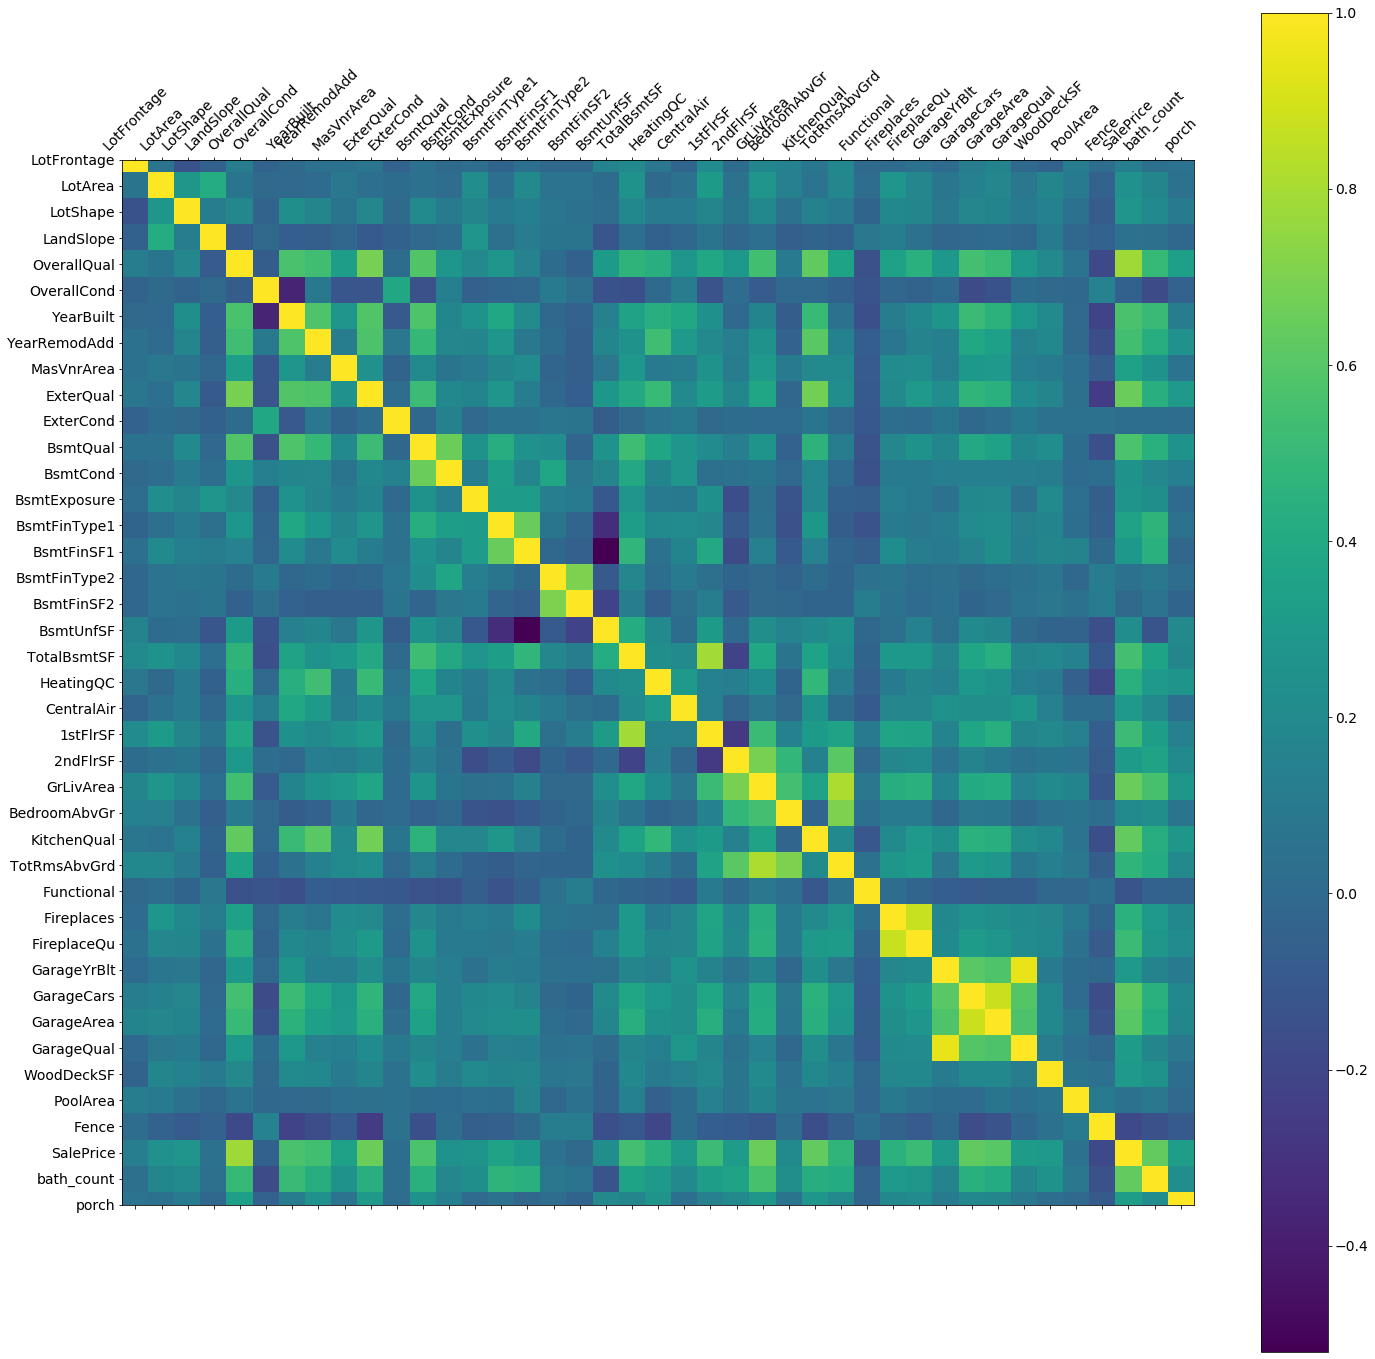

In [35]:
# plotting correlation matrix for first overview
f = plt.figure(figsize=(24, 24))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14);

In [36]:
# ordering correlation pairs sorted by strength of correlation (abs)

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(df, 100)

GarageYrBlt   GarageQual      0.948935
GarageCars    GarageArea      0.876181
Fireplaces    FireplaceQu     0.870111
GrLivArea     TotRmsAbvGrd    0.814468
TotalBsmtSF   1stFlrSF        0.787402
                                ...   
OverallQual   1stFlrSF        0.388258
YearRemodAdd  GarageCars      0.387651
OverallCond   ExterCond       0.384396
YearBuilt     CentralAir      0.382503
ExterQual     GrLivArea       0.378518
Length: 100, dtype: float64

In [37]:
# condensing the dataframe further to keep only columns showing significant signs of correlation 
# regarding sale price
# correlation threshold: 0.6
df = df[["SalePrice", "OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "bath_count", "GarageCars", "BsmtQual", "GarageArea"]].copy()

In [38]:
# pearson correlation matrix for chosen features
df.corr(method="pearson")

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,bath_count,GarageCars,BsmtQual,GarageArea
SalePrice,1.000000,0.784294,0.661325,0.659665,0.637032,0.632779,0.628013,0.568295,0.607230
OverallQual,0.784294,1.000000,0.537984,0.689373,0.626731,0.498822,0.547900,0.588717,0.508712
GrLivArea,0.661325,0.537984,1.000000,0.378518,0.352968,0.557381,0.411053,0.268412,0.418884
ExterQual,0.659665,0.689373,0.378518,1.000000,0.677613,0.437482,0.474038,0.520757,0.444846
KitchenQual,0.637032,0.626731,0.352968,0.677613,1.000000,0.424163,0.452972,0.460983,0.434092
bath_count,0.632779,0.498822,0.557381,0.437482,0.424163,1.000000,0.442462,0.443548,0.412994
GarageCars,0.628013,0.547900,0.411053,0.474038,0.452972,0.442462,1.000000,0.394582,0.876181
BsmtQual,0.568295,0.588717,0.268412,0.520757,0.460983,0.443548,0.394582,1.000000,0.350550
GarageArea,0.607230,0.508712,0.418884,0.444846,0.434092,0.412994,0.876181,0.350550,1.000000


### 6. Verifying assumptions

In [39]:
# preparing the dataframe: adding constant
df = sm.add_constant(df)

/home/luci/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


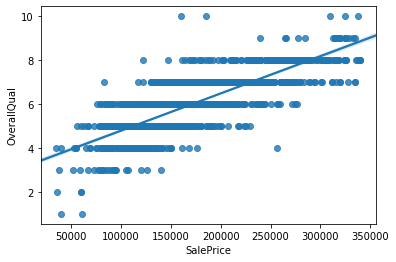

In [40]:
# attempt to visualize a trend line for sale price and selected features
sns.regplot(data=df, x="SalePrice", y="OverallQual");

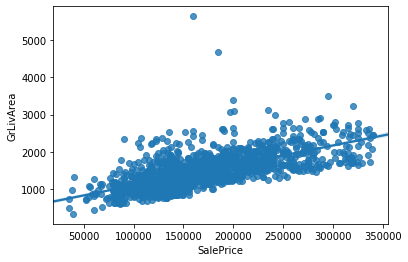

In [41]:
sns.regplot(data=df, x="SalePrice", y="GrLivArea");
# anotation: we can see some outliers here. not going to remove them now because I don't see why it would be 
# necessary yet

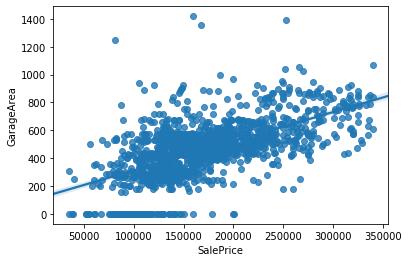

In [42]:
sns.regplot(data=df, x="SalePrice", y="GarageArea");
# some outliers too as well as houses without any garage. but we don't want to exclude these from the analysis

In [43]:
# using OLS for checking for regression coefficient
# using OLS over logistic regression because the sale price in theory is infinite and can't be expressed
# as a boolean value (as for example "sold (true/false)")
# (actually I am not 100% sure here, but let's assume OLS is the right choice in this case)

# first checking every feature by itself
y = df["SalePrice"]
x = df[["const", "OverallQual"]]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     2233.
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          6.11e-292
Time:                        18:21:23   Log-Likelihood:                -16691.
No. Observations:                1399   AIC:                         3.339e+04
Df Residuals:                    1397   BIC:                         3.340e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.653e+04   4691.711     -9.918      0.000   -5.57e+04   -3.73e+04
OverallQual  3.623e+04    766.705     47.251      0.000    3.47e+04    3.77e+04
==============================================================================
Omnibus:                       32.900   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.682
Skew:                           0.205   Prob(JB):                     3.63e-12
Kurtosis:                       3.857   Cond. No.                         30.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
y = df["SalePrice"]
x = df[["const", "GrLivArea"]]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     1086.
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          1.12e-176
Time:                        18:21:23   Log-Likelihood:                -16956.
No. Observations:                1399   AIC:                         3.392e+04
Df Residuals:                    1397   BIC:                         3.393e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.006e+04   3835.746     13.050      0.000    4.25e+04    5.76e+04
GrLivArea     81.5111      2.474     32.953      0.000      76.659      86.363
==============================================================================
Omnibus:                      138.380   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              863.493
Skew:                          -0.196   Prob(JB):                    3.12e-188
Kurtosis:                       6.829   Cond. No.                     5.01e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
y = df["SalePrice"]
x = df[["const", "ExterQual"]]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     1076.
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          1.70e-175
Time:                        18:21:23   Log-Likelihood:                -16959.
No. Observations:                1399   AIC:                         3.392e+04
Df Residuals:                    1397   BIC:                         3.393e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -7.61e+04   7602.594    -10.010      0.000    -9.1e+04   -6.12e+04
ExterQual   7.348e+04   2239.830     32.806      0.000    6.91e+04    7.79e+04
==============================================================================
Omnibus:                       54.614   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.294
Skew:                           0.434   Prob(JB):                     6.63e-15
Kurtosis:                       3.606   Cond. No.                         23.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
y = df["SalePrice"]
x = df[["const", "KitchenQual"]]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     954.1
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          4.09e-160
Time:                        18:21:23   Log-Likelihood:                -16994.
No. Observations:                1399   AIC:                         3.399e+04
Df Residuals:                    1397   BIC:                         3.400e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3.818e+04   6856.985     -5.568      0.000   -5.16e+04   -2.47e+04
KitchenQual  6.016e+04   1947.511     30.889      0.000    5.63e+04     6.4e+04
==============================================================================
Omnibus:                       35.081   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.754
Skew:                           0.312   Prob(JB):                     5.20e-10
Kurtosis:                       3.587   Cond. No.                         21.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
y = df["SalePrice"]
x = df[["const", "bath_count"]]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     932.9
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          2.29e-157
Time:                        18:21:23   Log-Likelihood:                -17001.
No. Observations:                1399   AIC:                         3.401e+04
Df Residuals:                    1397   BIC:                         3.402e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.365e+04   3698.861     17.209      0.000    5.64e+04    7.09e+04
bath_count  4.923e+04   1611.712     30.544      0.000    4.61e+04    5.24e+04
==============================================================================
Omnibus:                       87.528   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.920
Skew:                           0.578   Prob(JB):                     8.21e-25
Kurtosis:                       3.754   Cond. No.                         8.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
y = df["SalePrice"]
x = df[["const", "GarageCars"]]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     909.8
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          2.44e-154
Time:                        18:21:23   Log-Likelihood:                -17008.
No. Observations:                1399   AIC:                         3.402e+04
Df Residuals:                    1397   BIC:                         3.403e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.167e+04   3184.695     25.643      0.000    7.54e+04    8.79e+04
GarageCars  5.157e+04   1709.551     30.163      0.000    4.82e+04    5.49e+04
==============================================================================
Omnibus:                       46.169   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.220
Skew:                           0.360   Prob(JB):                     1.38e-13
Kurtosis:                       3.706   Cond. No.                         6.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
y = df["SalePrice"]
x = df[["const", "BsmtQual"]]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     666.4
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          1.81e-120
Time:                        18:21:23   Log-Likelihood:                -17086.
No. Observations:                1399   AIC:                         3.418e+04
Df Residuals:                    1397   BIC:                         3.419e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.417e+04   5429.811      6.293      0.000    2.35e+04    4.48e+04
BsmtQual     3.96e+04   1534.051     25.815      0.000    3.66e+04    4.26e+04
==============================================================================
Omnibus:                       75.181   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.238
Skew:                           0.587   Prob(JB):                     1.88e-19
Kurtosis:                       3.320   Cond. No.                         15.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
y = df["SalePrice"]
x = df[["const", "GarageArea"]]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     816.0
Date:                Sun, 17 Nov 2019   Prob (F-statistic):          9.92e-142
Time:                        18:21:23   Log-Likelihood:                -17037.
No. Observations:                1399   AIC:                         3.408e+04
Df Residuals:                    1397   BIC:                         3.409e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.946e+04   3095.377     28.900      0.000    8.34e+04    9.55e+04
GarageArea   176.0648      6.164     28.566      0.000     163.974     188.156
==============================================================================
Omnibus:                       35.351   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.511
Skew:                           0.210   Prob(JB):                     1.97e-13
Kurtosis:                       3.910   Cond. No.                     1.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Observations:
* we can see that all features seperately have a positive regression coefficient regarding the sale price
* all p-values for the individual features are below the threshold of 5%
* the R-squared value ranges between 0.62 and 0.37 and does not come close to reach a desired 1

##### Conclusions:
* all tested features do actually have an positive impact on the sale price: if the feature goes up/increases/gets "better" the sale price increases
* if out null hypothesis is that all tested features have absolutely no impact on the sale price, our p-value tells us that we can safely reject this hypothesis and instead assume that these features in fact do have an impact on the sale price
* since the r-squared value does not come close to 1 for all features tested, we can say that our models do not explain the variance in our sample to a sufficient amount
* the feature with the highest regression coefficient by itself is the OverallQual

##### What can we do?
Let's try to combine all features into one model and see if the variance explained by our model increases.

In [51]:
# OLS model for all features combined
features = ["OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "bath_count", "GarageCars", "BsmtQual", "GarageArea"]

y = df["SalePrice"]
x = df[["const"] + features]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     631.0
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:21:23   Log-Likelihood:                -16286.
No. Observations:                1399   AIC:                         3.259e+04
Df Residuals:                    1390   BIC:                         3.264e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.994e+04   5029.517    -19.870      0.000    -1.1e+05   -9.01e+04
OverallQual  1.336e+04    981.429     13.617      0.000    1.14e+04    1.53e+04
GrLivArea      30.9365      2.037     15.186      0.000      26.940      34.933
ExterQual    9527.5984   2163.044      4.405      0.000    5284.415    1.38e+04
KitchenQual  1.176e+04   1699.505      6.918      0.000    8423.098    1.51e+04
bath_count   1.059e+04   1289.637      8.212      0.000    8060.658    1.31e+04
GarageCars   6821.5483   2209.522      3.087      0.002    2487.190    1.12e+04
BsmtQual     7038.1725   1134.954      6.201      0.000    4811.765    9264.580
GarageArea     28.5281      7.584      3.762      0.000      13.652      43.405
==============================================================================
Omnibus:                      472.223   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9414.000
Skew:                          -1.063   Prob(JB):                         0.00
Kurtosis:                      15.529   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Observations:
* we can see that in combination all features still have a positive regression coefficient regarding the sale price
* all p-values for the individual features are below the threshold of 5%
* the adjusted R-squared value now reaches 0.783 

##### Conclusions:
* all tested features in combination do still have an positive impact on the sale price
* if our null hypothesis is that all tested features together have absolutely no impact on the sale price, our p-value tells us that we can safely reject this hypothesis and instead assume that these features together do have an impact on the sale price
* the adjusted r-squared value now comes closer to 1 which means that all features together do explain the variance in sale price in our sample better that all features by themselves (surprise!)
* the feature with the highest regression coefficient still is the OverallQual with a value of ~ 13.360 which means that an increase of overall building quality by one point on the scale would result in an increase of the sale price of the building by roughly 13.360 Dollars.

##### What to do next?
Since the type and range of the features differs quite a lot (e.g. continuous and potentially infinite values such as price and area versus categorical or boolean values such as quality measures) I wonder if the models values will change when all features are normalized.

In [52]:
# defining normalization funtion

def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y


In [53]:
# nomalizing column values
df_norm = df.copy()
cols_to_normalize = ["SalePrice", "OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "bath_count", "GarageCars", "BsmtQual", "GarageArea"]

for col in cols_to_normalize:
    df_norm[col] = normalize(df[col])



In [54]:
df.head()

,const,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,bath_count,GarageCars,BsmtQual,GarageArea
0,1.0,208500,7,1710,4,4,3.5,2,4.0,548
1,1.0,181500,6,1262,3,3,2.5,2,4.0,460
2,1.0,223500,7,1786,4,4,3.5,2,4.0,608
3,1.0,140000,7,1717,3,4,2.0,3,3.0,642
4,1.0,250000,8,2198,4,4,3.5,3,4.0,836


In [55]:
# running OLS model again on normalized dataset

y = df_norm["SalePrice"]
x = df_norm[["const"] + features]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     631.0
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:21:23   Log-Likelihood:                 1381.0
No. Observations:                1399   AIC:                            -2744.
Df Residuals:                    1390   BIC:                            -2697.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1900      0.012    -16.359      0.000      -0.213      -0.167
OverallQual     0.3942      0.029     13.617      0.000       0.337       0.451
GrLivArea       0.5382      0.035     15.186      0.000       0.469       0.608
ExterQual       0.0937      0.021      4.405      0.000       0.052       0.135
KitchenQual     0.1156      0.017      6.918      0.000       0.083       0.148
bath_count      0.1736      0.021      8.212      0.000       0.132       0.215
GarageCars      0.0894      0.029      3.087      0.002       0.033       0.146
BsmtQual        0.1153      0.019      6.201      0.000       0.079       0.152
GarageArea      0.1326      0.035      3.762      0.000       0.063       0.202
==============================================================================
Omnibus:                      472.223   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9414.000
Skew:                          -1.063   Prob(JB):                         0.00
Kurtosis:                      15.529   Cond. No.                         29.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# running OLS model again on non normalized dataset for comparison

y = df["SalePrice"]
x = df[["const"] + features]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     631.0
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:21:23   Log-Likelihood:                -16286.
No. Observations:                1399   AIC:                         3.259e+04
Df Residuals:                    1390   BIC:                         3.264e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -9.994e+04   5029.517    -19.870      0.000    -1.1e+05   -9.01e+04
OverallQual  1.336e+04    981.429     13.617      0.000    1.14e+04    1.53e+04
GrLivArea      30.9365      2.037     15.186      0.000      26.940      34.933
ExterQual    9527.5984   2163.044      4.405      0.000    5284.415    1.38e+04
KitchenQual  1.176e+04   1699.505      6.918      0.000    8423.098    1.51e+04
bath_count   1.059e+04   1289.637      8.212      0.000    8060.658    1.31e+04
GarageCars   6821.5483   2209.522      3.087      0.002    2487.190    1.12e+04
BsmtQual     7038.1725   1134.954      6.201      0.000    4811.765    9264.580
GarageArea     28.5281      7.584      3.762      0.000      13.652      43.405
==============================================================================
Omnibus:                      472.223   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9414.000
Skew:                          -1.063   Prob(JB):                         0.00
Kurtosis:                      15.529   Cond. No.                     1.13e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
df_norm["GrLivArea"].max()

1.0

#### Observations:
* we can see that all normalized features still have a positive regression coefficient regarding the normalized sale price
* all p-values for the individual features are below the threshold of 5%
* the adjusted R-squared value is still at 0.783
* the individual values for the features regression coefficient have changed in comparison to the first attempt without normalization

##### Why could this be?
After a quick research I found that the question "When to normalize my data?" can't be answered with one simple sentence. The change in the regression coefficients can partly be explained by the altered rate by which our dependent variable changes when the independent features change due to the normalization.
In comparison to the first attempt these coefficients now are slightly better readable and comparable due to sharing the same length.
What I find confusing though is the change in coefficient value for some features (e.g. GrLivArea) - using the normalized values suddenly the feature with the highest regression coefficient is GrLivArea instead of OverallQual. 

##### What to do next?
I wonder if the change in the slope for some features may have to do with the scaling of the values from the min and max value. In the beginning I removed outliers from the sale price but not from other features. Let's try this.

In [58]:
# removing outliers from GrLivArea
df_tmp = df.copy()
q1, q3 = np.percentile(df_tmp["GrLivArea"],[25,75])
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr) 
upper_bound = q3 + (1.5 * iqr)

# getting row indexes of rows where "GrLivArea" is < q1 or > q3 and dropping them
rows_to_drop = df_tmp.index[(df_tmp["GrLivArea"] < lower_bound) | (df_tmp["GrLivArea"] > upper_bound)].tolist()
df_tmp = df_tmp.drop(rows_to_drop)


In [59]:
# normalizing again
df_norm = df_tmp.copy()
cols_to_normalize = ["SalePrice", "OverallQual", "GrLivArea", "ExterQual", "KitchenQual", "bath_count", "GarageCars", "BsmtQual", "GarageArea"]

for col in cols_to_normalize:
    df_norm[col] = normalize(df[col])

In [60]:
# running OLS model again on normalized dataset with removed outliers in GrLivArea columns

y = df_norm["SalePrice"]
x = df_norm[["const"] + features]
lin_reg = sm.OLS(y, x)
result = lin_reg.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     736.7
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:21:23   Log-Likelihood:                 1474.1
No. Observations:                1378   AIC:                            -2930.
Df Residuals:                    1369   BIC:                            -2883.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2113      0.011    -19.409      0.000      -0.233      -0.190
OverallQual     0.3778      0.027     14.033      0.000       0.325       0.431
GrLivArea       0.6739      0.037     18.416      0.000       0.602       0.746
ExterQual       0.1089      0.020      5.446      0.000       0.070       0.148
KitchenQual     0.1163      0.016      7.445      0.000       0.086       0.147
bath_count      0.1624      0.020      8.252      0.000       0.124       0.201
GarageCars     -0.0027      0.028     -0.097      0.922      -0.058       0.052
BsmtQual        0.1210      0.017      6.992      0.000       0.087       0.155
GarageArea      0.2365      0.034      6.994      0.000       0.170       0.303
==============================================================================
Omnibus:                       35.856   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.230
Skew:                           0.077   Prob(JB):                     1.03e-17
Kurtosis:                       4.157   Cond. No.                         30.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Observations:
* after removing outliers from the GrLivArea column the coefficient for the feature is even higher
* the feature GarageCars now is a negative coefficient
* also the adjusted r-squared and f-statistic value have increased

##### Why could this be?
The increase in adjusted r-squared and f-statistic should mean that the model now is more fitting and explains more variance in the dataset. In this case I suspect that our model did not improved but some variance was removed by removing outlier rows.
This could also explain why the regression coefficient is even higher now.
It may be that by removing outliers both in sale price and GrLivArea the proportions of the dataset shifted so that GarageCars now has a slight negative impact on the sale price.

##### What to do next?
Since espacially the last observations makes me think I am going a wrong way here I am going to just stick to the non normalized dataframe regarding my conclusions. 
Not going to delete the previous billion lines because someone may find them entertaining. ;-)